## Importing and initializing stuff

In [1]:
# Import(ant) stuff

import os

import cartopy.crs as ccrs
import numpy as np
import pandas as pandas
import xarray

# import and setup matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

import ucat
import ddeq

from cartopy import crs as ccrs, feature as cfeature
import cluster #my method
import matplotlib.patheffects as pe
import time
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
# Define coordinate reference systems used by the tool, the SMARTCARB model domain and the path to SMARTCARB data:

# DHDN / Soldner Berlin
CRS = ccrs.epsg(3068) #Area of Berlin from epsg parameter dataset
WGS84 = ccrs.PlateCarree() #Projection

DOMAIN = ddeq.misc.Domain.from_nml(os.path.join(os.path.dirname(ddeq.__file__), 'data', 'INPUT_ORG'))

ROOT = '/project/coco2/fileshare/WP4/SMARTCARB/'

EMISSIONS_DATA_PATH = os.path.join(ROOT, 'timeseries')
SMARTCARB_DATA_PATH = os.path.join(ROOT, 'level2')
SMARTCARB_MODEL_PATH = os.path.join(ROOT, 'COSMO')

In [3]:
# list of point sources
sources = ddeq.misc.read_point_sources()
#sources

In [4]:
# Getting the data
filename = os.path.join(SMARTCARB_DATA_PATH, 'Sentinel_7_CO2_2015042311_o1670_l0483.nc') #path of one file
data_level2 = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='medium', no2_noise_scenario='high')
#data_level2

In [5]:
# List of all filenames
filenames_all = os.listdir(SMARTCARB_DATA_PATH)

## Plume detection algorithm (from their example notebook)
Plumes are regions how satellite pixels where CO2/NO2 values are significantly enhanced above the background
\begin{equation}
SNR = \frac{X - X_\mathrm{bg}}{\sqrt{\sigma_\mathrm{random}^2 + \sigma_\mathrm{sys}^2}} \geq z_\mathrm{thr}
\end{equation}
The value $X$ is computed by applying a Gaussian filter (other filters are possible) with size `filter_size` (default: 0.5 pixels). The background $X_\mathrm{bg}$ is computed using a median filter (size = 100 pixels). The threshold $z_\mathrm{thr}$ is computed for z-statistics using a probability $q$ (default: 0.99). Pixels for which above equation is true, are connected to regions using a labeling algorithm considering (horizontal, vertical and diagonal neighbors). Regions that overlap that are within the radius defined in `sources` of a point sources are assigned to the source. A region can be assigned to more than one source (overlapping plumes).

In [6]:
filename = os.path.join(SMARTCARB_DATA_PATH, 'Sentinel_7_CO2_2015042311_o1670_l0483.nc')
data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)

data = ddeq.dplume.detect_plumes(data, sources, variable='NO2', variable_std='NO2_std',
                                 filter_type='gaussian', filter_size=0.5)

data.attrs.update(
    DESCRIPTION = ('Synthetic XCO2 and NO2 satellite image with ',
                   'auxiliary data for estimating CO2/NOx ',
                   'emissions of cities and point sources'),
    DATAORIGIN = 'SMARTCARB study',
    CREATOR = 'Gerrit Kuhlmann',
    EMAIL = 'gerrit.kuhlmann@empa.ch',
    AFFILIATION = 'Empa Duebendorf, Switzerland',
    DATE_CREATED = pandas.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
)

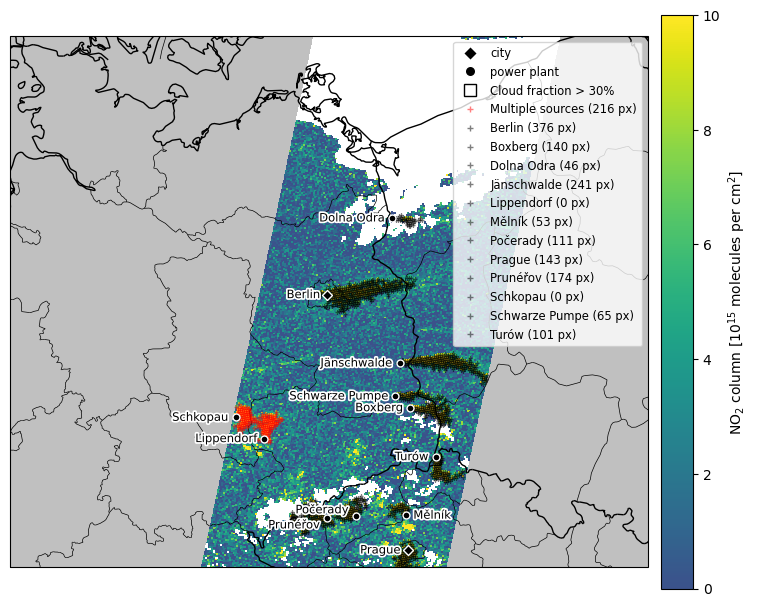

In [7]:
ddeq.vis.visualize(data, trace_gas='NO2', domain=DOMAIN, add_wind=False, do_zoom=False, show_clouds=True, vlim=(-3,3), show_true_plumes=True);

This the example from their notebook

In [9]:
import cluster as clt

In [10]:
i=333
# Get the SMARTCARB data from files and save the data to lon, lat and no2
filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
data = ddeq.smartcarb.read_level2(
    filename,
    co2_noise_scenario=None,
    no2_noise_scenario='low',
    co_noise_scenario=None,
    only_observations=True,
)
lon_m = np.array(data["lon"])
lat_m = np.array(data["lat"])
no2_m = np.array(data["NO2"])

#no2_m_padded = np.pad(no2_m, pad_width=1, mode='constant', constant_values=np.nan)

# Remove points outside domain
domain_extent=[8.30719191586997, 18.170863673993093, 49.978223611443795, 54.694193446535714]
area_boolean = np.logical_and(np.logical_and(lon_m>=domain_extent[0], lon_m<=domain_extent[1]), np.logical_and(lat_m>=domain_extent[2], lat_m<=domain_extent[3]))
no2_m[~area_boolean] = np.nan

lon = lon_m.flatten()
lat = lat_m.flatten()
no2 = no2_m.flatten()

#nan_indices = np.where(np.isnan(no2))
not_nan = np.logical_not(np.isnan(no2))

lon_notNaN = lon[not_nan]
lat_notNaN = lat[not_nan]
no2_notNaN = no2[not_nan]
lon_NaN = lon[~not_nan]
lat_NaN = lat[~not_nan]


# Continue if there are no points in the file
if len(no2_notNaN) == 0: 
    number_of_facilities_in_plumes_per_file.append([])    
else:
    # Plume detection
    clusters = clt.density_based_clustering_with_varying_radius(
        np.transpose([lon_notNaN, lat_notNaN]),
        no2_notNaN,
        radius_func="default",
        n_clusters="auto",
        point_value_threshold="stds_from_median",
        stds=3.3,
        distance_matrix="euclidean",
        radius_func_sigmas_threshold=1.3,
        max_points_in_start_radius=5,
        local_box_size=3,
        verbose=True,
    )

Found  16  clusters


# Comparing my method and their method

They use NO2 and CO2 data in their plume detection. <br>
I only use NO2

"Finally, in the third step, all connected regions that do not intersect with the source region are removed leaving only regions
5 that overlap with the source of the plume (Fig. 3d). For cities, the “source region” is deﬁned by a circle with a radius of 15 km
and for point sources by a circle with a radius of 5 km. The last step may remove regions that are part of the real plume but
separated from the source by weak signals or missing values"

So they on only consider the areas with known power plants and cities 

So so I can use this as a way to compare the finding of these spesific plumes.

## GAMEPLAN 
Step 1: Find the location of Berlin and the power plants and use the same radius as the authors. <br>
Step 2: Assign a plume to the source if its in the radius. Assign adjacent plumes also?<br>
Step 3: Find cases where my method and their method disagrees. If multiple plumes get assigned to source, inspect more closely. If no plume gets found even with non-missing values inspect more closely. <br>
Step 4: Compare the results per source. Compare computation time. <br>

Maybe future steps: Compare the assigned pixels.

## Quick comparison example

### My

In [8]:
# Data
filename = os.path.join(SMARTCARB_DATA_PATH, 'Sentinel_7_CO2_2015042311_o1670_l0483.nc')
data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
lon = np.array(data['lon']).flatten()
lat = np.array(data['lat']).flatten()
no2 = np.array(data['NO2']).flatten()

# Data in the proper format
points = np.transpose([lon,lat])
not_nan = np.logical_not(np.isnan(no2))
points = points[not_nan]
no2_notnan = no2[not_nan]

In [9]:
# My clustering algorithm
clusters = cluster.density_based_clustering_with_varying_radius(points,
                                                    no2_notnan,
                                                    radius_func='default', 
                                                    n_clusters='auto',
                                                    point_value_threshold='stds_from_mean', 
                                                    stds=3.2, 
                                                    distance_matrix="euclidean",
                                                    radius_func_sigmas_threshold=1.4, 
                                                    max_points_in_start_radius=5, 
                                                    local_box_size=3,
                                                    verbose=True)

threshold value: 1.8104447e+16
Found  20  clusters


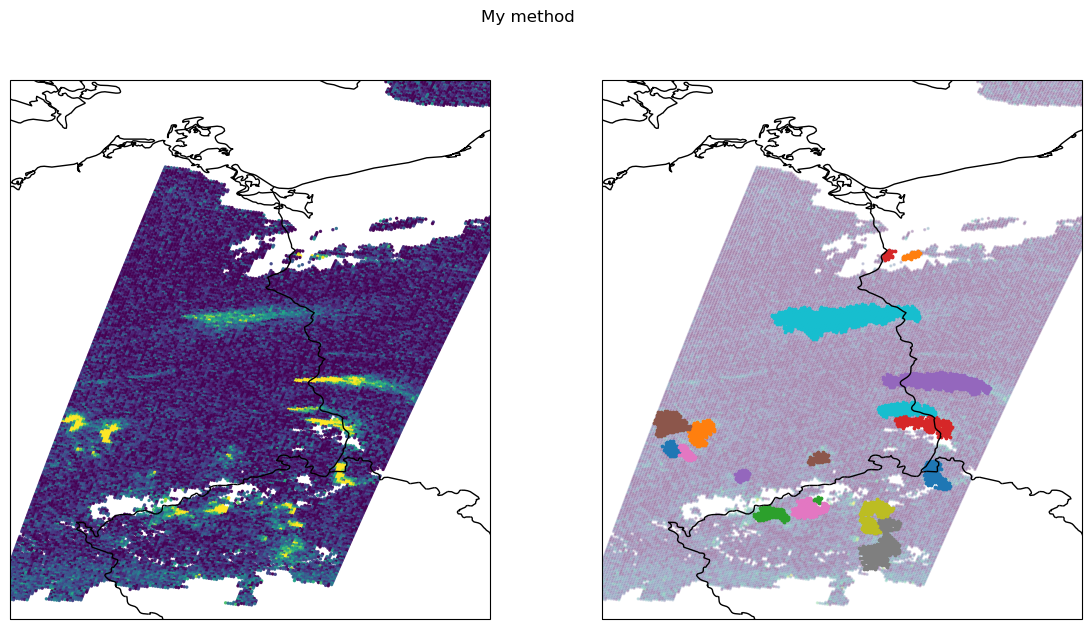

In [10]:
fig, axs = plt.subplots(1,2, figsize=(14,7), subplot_kw={'projection': ccrs.PlateCarree()})

ax = axs[0]
ax.set_extent([5.86+5.5, 15.04+1.5, 47.27+2, 55.09])
pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=2, alpha=0.9, transform=ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
ax.coastlines()

ax = axs[1]
ax.set_extent([5.86+5.5, 15.04+1.5, 47.27+2, 55.09])
pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=2, alpha=0.2, transform=ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
ax.coastlines()
#fig.colorbar(pcm, ax=ax)

for i in range(1,int(clusters.max())+1):
    #print(i)
    ax.scatter(points[clusters == i][:,0], points[clusters == i][:,1], s=3)
    

plt.suptitle("My method")
plt.show()

### Theirs

In [11]:
filename = os.path.join(SMARTCARB_DATA_PATH, 'Sentinel_7_CO2_2015042311_o1670_l0483.nc')
data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)

data = ddeq.dplume.detect_plumes(data, sources, variable='NO2', variable_std='NO2_std',
                                 filter_type='gaussian', filter_size=0.5)

data.attrs.update(
    DESCRIPTION = ('Synthetic XCO2 and NO2 satellite image with ',
                   'auxiliary data for estimating CO2/NOx ',
                   'emissions of cities and point sources'),
    DATAORIGIN = 'SMARTCARB study',
    CREATOR = 'Gerrit Kuhlmann',
    EMAIL = 'gerrit.kuhlmann@empa.ch',
    AFFILIATION = 'Empa Duebendorf, Switzerland',
    DATE_CREATED = pandas.Timestamp.now().strftime('%Y-%m-%d %H:%M'),
)

lon = np.array(data['lon']).flatten()
lat = np.array(data['lat']).flatten()
no2 = np.array(data['NO2']).flatten()

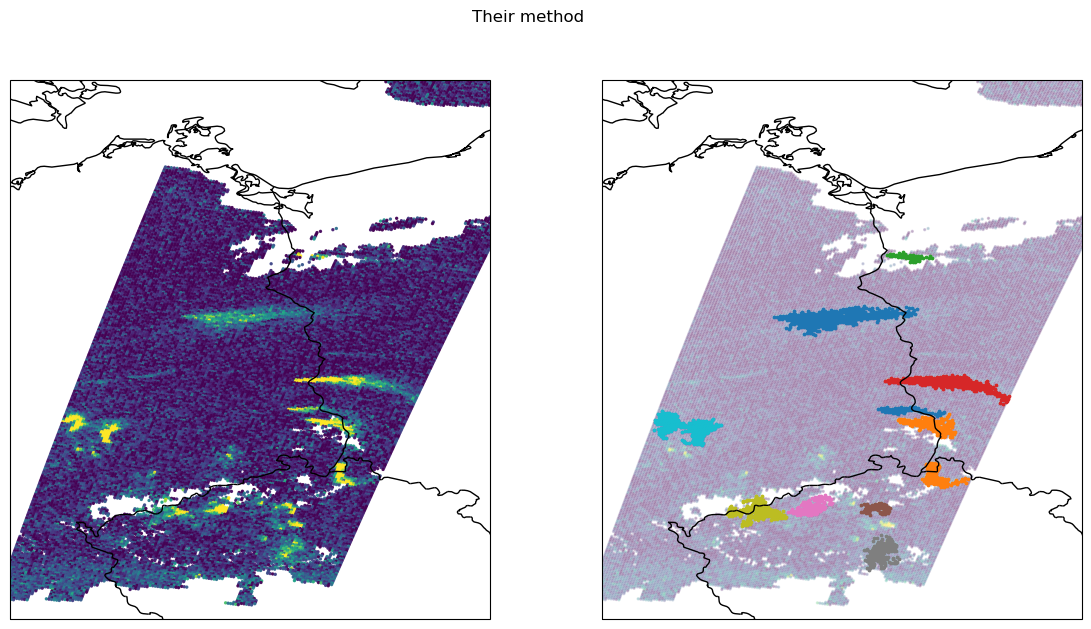

In [12]:
fig, axs = plt.subplots(1,2, figsize=(14,7), subplot_kw={'projection': ccrs.PlateCarree()})

ax = axs[0]
ax.set_extent([5.86+5.5, 15.04+1.5, 47.27+2, 55.09])
pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=2, alpha=0.9, transform=ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
ax.coastlines()

ax = axs[1]
ax.set_extent([5.86+5.5, 15.04+1.5, 47.27+2, 55.09])
pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=2, alpha=0.2, transform=ccrs.Geodetic())
ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
ax.coastlines()

for i in range(data['detected_plume'].shape[2]):
    is_plume = np.array(data['detected_plume'][:,:,i]).flatten()
    ax.scatter(lon[is_plume], lat[is_plume], s=3)

plt.suptitle("Their method")
plt.show()

## My method 

In [13]:
%%time

my_clusters_per_file = []
my_time_spent_per_file = []

#for i in range(20):
for i in range(len(filenames_all)):
    
    # Print progress
    print(f"{i+1}/{len(filenames_all)} file")
    
    # Find the data
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)

    # Data in proper format
    lon = np.array(data['lon']).flatten()
    lat = np.array(data['lat']).flatten()
    no2 = np.array(data['NO2']).flatten()
    not_nan = np.logical_not(np.isnan(no2))
    lon = lon[not_nan]
    lat = lat[not_nan]
    no2 = no2[not_nan]    
    points = np.transpose([lon,lat])

    
    
    # Time
    start_time = time.time()
    
    
    try:
        # My clustering algorithm
        clusters = cluster.density_based_clustering_with_varying_radius(points,
                                                    no2,
                                                    radius_func='default', 
                                                    n_clusters='auto',
                                                    point_value_threshold='stds_from_mean', 
                                                    stds=3.2, 
                                                    distance_matrix="euclidean",
                                                    radius_func_sigmas_threshold=1.3, 
                                                    max_points_in_start_radius=5, 
                                                    local_box_size=3,
                                                    verbose=True)
        
        # Append clusters to the list
        my_clusters_per_file.append(clusters)
        
    except:
        my_clusters_per_file.append(np.array([]))
        

    
    # Time
    my_time_spent_per_file.append(time.time() - start_time)
    print(f"Execution time: {time.time() - start_time} seconds.")

1/3124 file
threshold value: 1.1853389e+16
Found  32  clusters
Execution time: 7.745103597640991 seconds.
2/3124 file
threshold value: 8904452000000000.0
Found  33  clusters
Execution time: 45.74038624763489 seconds.
3/3124 file
Execution time: 8.678436279296875e-05 seconds.
4/3124 file
threshold value: 1.2881648e+16
Found  12  clusters
Execution time: 9.513816833496094 seconds.
5/3124 file
No clusters found. All points are too close to the mean. Consider lowering stds. Currently stds=3.200000.
Execution time: 0.0008101463317871094 seconds.
6/3124 file
Execution time: 8.893013000488281e-05 seconds.
7/3124 file
Execution time: 3.314018249511719e-05 seconds.
8/3124 file
threshold value: 1.3173934e+16
Found  6  clusters
Execution time: 0.2621440887451172 seconds.
9/3124 file
Execution time: 4.553794860839844e-05 seconds.
10/3124 file
No clusters found. All points are too close to the mean. Consider lowering stds. Currently stds=3.200000.
Execution time: 0.0007839202880859375 seconds.
11/3

In [18]:
# Plot an example

def plot_my_example(i):
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    lon = np.array(data['lon']).flatten()
    lat = np.array(data['lat']).flatten()
    no2 = np.array(data['NO2']).flatten()
    not_nan = np.logical_not(np.isnan(no2))
    #points = np.transpose([lon,lat])
    #points = points[not_nan]
    lon = lon[not_nan]
    lat = lat[not_nan]
    no2 = no2[not_nan]
    
    clusters = my_clusters_per_file[i]

    fig, axs = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)

    extent = [np.min(lon)-0.5, np.max(lon)+0.5, np.min(lat)-0.5, np.max(lat)+0.5]
    
    ax = axs[0]
    ax.set_extent(extent)
    pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=0.2, alpha=0.9, transform=ccrs.Geodetic())
    ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
    ax.coastlines()

    # Plot sources
    for i in range(len(sources['source'])):
        ax.scatter(sources['lon_o'][i], sources['lat_o'][i], c='black', path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=1)], s=2, alpha=0.5)
        ax.text(sources['lon_o'][i], sources['lat_o'][i]+0.05, sources['source'][i].data, c='black', size=6, alpha=0.6, path_effects=[pe.withStroke(linewidth=2, foreground="white")]).set_clip_on(True)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'gray'}
    gl.ylabel_style = {'size': 7, 'color': 'gray'}
    
    ax = axs[1]
    ax.set_extent(extent)
    pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=0.2, alpha=0.2, transform=ccrs.Geodetic())
    ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
    ax.coastlines()
    #fig.colorbar(pcm, ax=ax)
    
    # Plot clusters
    if len(clusters)!=0 and int(np.max(clusters))!=0:
        for i in range(1,int(np.max(clusters))+1):
            ax.scatter(lon[clusters == i], lat[clusters == i], s=1)
    else:
        print("no clusters")
        
    # Plot sources
    for i in range(len(sources['source'])):
        ax.scatter(sources['lon_o'][i], sources['lat_o'][i], c='black', path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.5)], s=2, alpha=0.5)
        ax.text(sources['lon_o'][i], sources['lat_o'][i]+0.05, sources['source'][i].data, c='black', size=6, alpha=0.6, path_effects=[pe.withStroke(linewidth=2, foreground="white")]).set_clip_on(True)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'gray'}
    gl.ylabel_style = {'size': 7, 'color': 'gray'}
    
    plt.suptitle("My method")
    plt.show()

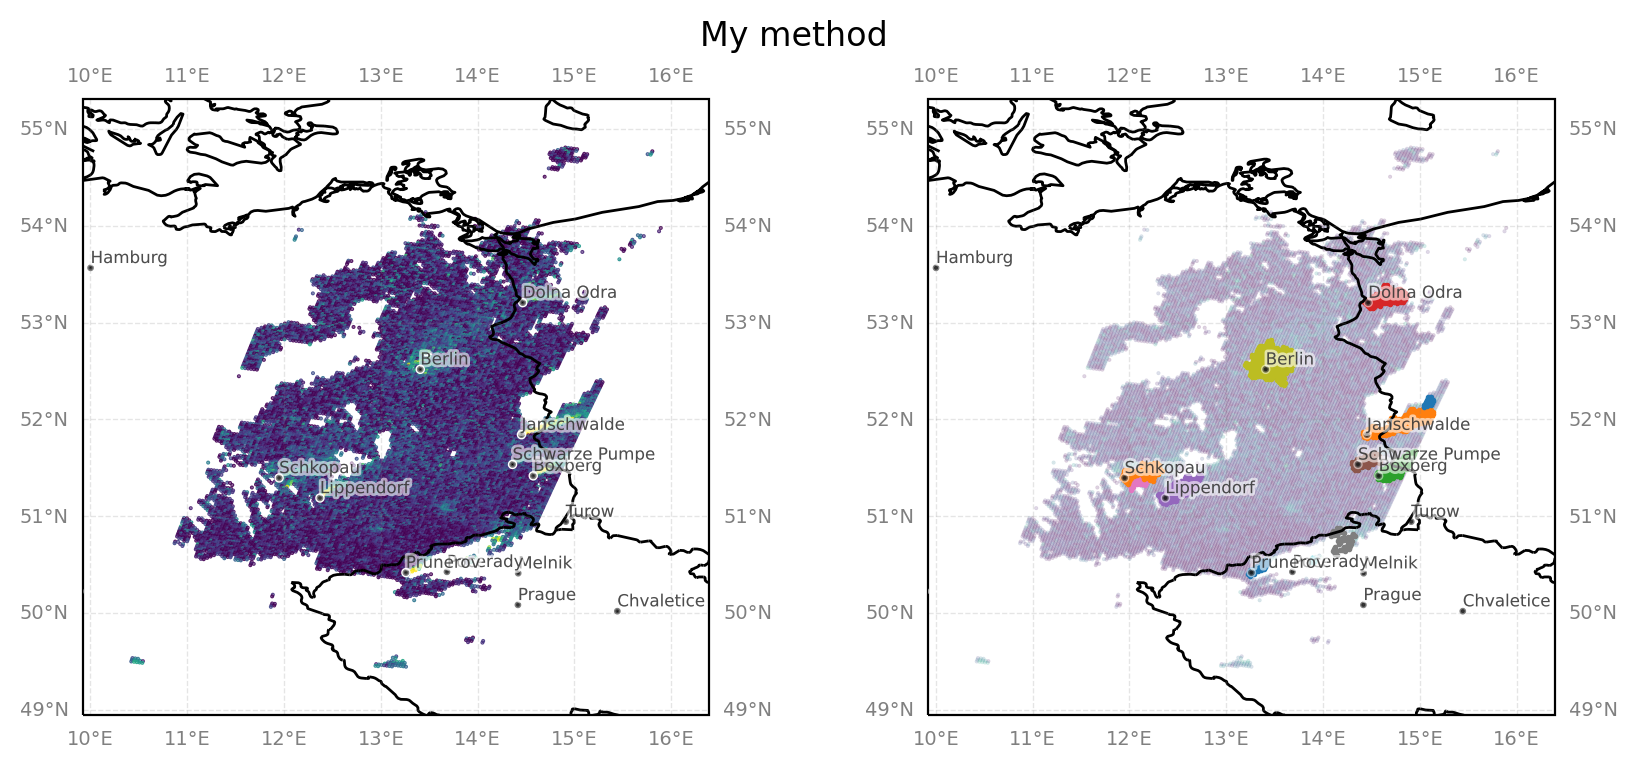

In [488]:
plot_my_example(3)

## Their method

In [14]:
%%time

their_clusters_per_file = []
their_time_spent_per_file = []

#for i in range(20):
for i in range(len(filenames_all)):
    
    # Print progress
    print(f"{i+1}/{len(filenames_all)} file")
    start_time = time.time()
    
    # Find the data
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    
    # Their method
    data_plumes = ddeq.dplume.detect_plumes(data, sources, variable='NO2', variable_std='NO2_std',
                                 filter_type='gaussian', filter_size=0.5)
    
    # Append to the lists
    try:
        their_clusters_per_file.append(data_plumes['detected_plume'])
    except:
        their_clusters_per_file.append(np.array([]))
    their_time_spent_per_file.append(time.time() - start_time)
    
    print(f"Execution time: {time.time() - start_time} seconds.")

1/3124 file
Execution time: 21.24221181869507 seconds.
2/3124 file
Execution time: 20.32266068458557 seconds.
3/3124 file
Execution time: 12.235765218734741 seconds.
4/3124 file
Execution time: 20.103167057037354 seconds.
5/3124 file
Execution time: 13.152626037597656 seconds.
6/3124 file
Sources not in swath.
Execution time: 2.194808006286621 seconds.
7/3124 file
Sources not in swath.
Execution time: 2.480125665664673 seconds.
8/3124 file
Execution time: 13.951241493225098 seconds.
9/3124 file
Execution time: 12.947145462036133 seconds.
10/3124 file
Execution time: 11.958064556121826 seconds.
11/3124 file
Execution time: 11.523049116134644 seconds.
12/3124 file
Execution time: 15.940610885620117 seconds.
13/3124 file
Execution time: 17.674528121948242 seconds.
14/3124 file
Execution time: 17.11242365837097 seconds.
15/3124 file
Execution time: 18.340100049972534 seconds.
16/3124 file
Execution time: 9.733832120895386 seconds.
17/3124 file
Execution time: 11.658388376235962 seconds.
18

In [22]:
def plot_their_example(i):

    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    lon = np.array(data['lon']).flatten()
    lat = np.array(data['lat']).flatten()
    no2 = np.array(data['NO2']).flatten()
    not_nan = np.logical_not(np.isnan(no2))
    lon_notnan = lon[not_nan]
    lat_notnan = lat[not_nan]
    no2_notnan = no2[not_nan]
    
    
    clusters = their_clusters_per_file[i]

    fig, axs = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=200)

    extent = [np.min(lon_notnan)-0.5, np.max(lon_notnan)+0.5, np.min(lat_notnan)-0.5, np.max(lat_notnan)+0.5]
    
    ax = axs[0]
    ax.set_extent(extent)
    pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=0.2, alpha=0.9, transform=ccrs.Geodetic())
    ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
    ax.coastlines()
    
    # Plot sources
    for i in range(len(sources['source'])):
        ax.scatter(sources['lon_o'][i], sources['lat_o'][i], c='black', path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.5)], s=2, alpha=0.5)
        ax.text(sources['lon_o'][i], sources['lat_o'][i]+0.05, sources['source'][i].data, c='black', size=6, alpha=0.6, path_effects=[pe.withStroke(linewidth=2, foreground="white")]).set_clip_on(True)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'gray'}
    gl.ylabel_style = {'size': 7, 'color': 'gray'}
    
    ax = axs[1]
    ax.set_extent(extent)
    pcm = ax.scatter(lon, lat, c=no2, vmin=0, vmax=1.7e16, s=0.2, alpha=0.2, transform=ccrs.Geodetic())
    ax.add_feature(cfeature.BORDERS, alpha=1, linewidth=1)
    ax.coastlines()

    # Plot clusters
    for i in range(clusters.shape[2]):
        is_plume = np.array(clusters[:,:,i]).flatten()
        ax.scatter(lon[is_plume], lat[is_plume], s=1)
        
    # Plot sources
    for i in range(len(sources['source'])):
        ax.scatter(sources['lon_o'][i], sources['lat_o'][i], c='black', path_effects=[pe.withStroke(linewidth=2, foreground="white", alpha=0.5)], s=2, alpha=0.5)
        ax.text(sources['lon_o'][i], sources['lat_o'][i]+0.05, sources['source'][i].data, c='black', size=6, alpha=0.6, path_effects=[pe.withStroke(linewidth=2, foreground="white")]).set_clip_on(True)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.2, linestyle='--')
    gl.xlabel_style = {'size': 7, 'color': 'gray'}
    gl.ylabel_style = {'size': 7, 'color': 'gray'}

    plt.suptitle("Their method")
    plt.show()

## Result analysis                    

- Visualisations

In [19]:
# Visualisation of results
#i=7
##plot_my_example(i)
#plot_their_example(i)

In [107]:
sources

<xarray.Dataset>
Dimensions:  (source: 19)
Coordinates:
  * source   (source) object 'Belchatow' 'Berlin' ... 'Staudinger' 'Turow'
Data variables:
    lon_o    (source) float64 19.33 13.41 14.57 15.44 ... 14.36 8.957 14.91
    lat_o    (source) float64 51.27 52.52 51.42 50.02 ... 51.53 50.09 50.94
    type     (source) object 'power plant' 'city' ... 'power plant'
    UTF-8    (source) object 'Bełchatów' 'Berlin' ... 'Staudinger' 'Turów'
    radius   (source) float64 5.0 15.0 5.0 5.0 5.0 15.0 ... 5.0 5.0 5.0 5.0 5.0

In [15]:
# Sources found

disagreeing_file = []
disagreeing_source = []

for i in range(len(my_clusters_per_file)):
    
    # Get plume detection data
    if len(their_clusters_per_file[i]) != 0: 
        is_their_plume = np.array(their_clusters_per_file[i].sum(axis=2,dtype=bool)).flatten()
    else:
        is_their_plume = np.array([],dtype=bool)
    is_my_plume = np.array(my_clusters_per_file[i],dtype=bool)

    # Get data
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    not_nan = np.logical_not(np.isnan(np.array(data['NO2']).flatten()))
    my_lon = np.array(data['lon']).flatten()[not_nan][is_my_plume]
    my_lat = np.array(data['lat']).flatten()[not_nan][is_my_plume]
    their_lon = np.array(data['lon']).flatten()[is_their_plume]
    their_lat = np.array(data['lat']).flatten()[is_their_plume]

    # Coordinates of sources and datapoints in radians
    source_coordinates = np.radians(np.transpose([sources['lon_o'].data, sources['lat_o'].data]))
    my_plume_point_coordinates = np.radians(np.transpose([my_lon,my_lat]))
    their_plume_point_coordinates = np.radians(np.transpose([their_lon,their_lat]))
    
    # Distances between sources and points in kilometers
    my_distance_matrix = haversine_distances(source_coordinates, my_plume_point_coordinates) * 6371  # multiply by Earth radius to get kilometers
    their_distance_matrix = haversine_distances(source_coordinates, their_plume_point_coordinates) * 6371  # multiply by Earth radius to get kilometers
    
    # Is there a plume in radius of a source
    if my_distance_matrix.shape[1] != 0: # is nonempy
        is_my_plume_in_radius = my_distance_matrix.min(axis=1) < np.array(sources['radius'].data)
    else: 
        is_my_plume_in_radius = np.array([False]*len(source_coordinates))  
    if their_distance_matrix.shape[1] != 0: # is nonempy
        is_their_plume_in_radius = their_distance_matrix.min(axis=1) < np.array(sources['radius'].data)
    else:
        is_their_plume_in_radius = np.array([False]*len(source_coordinates))

    # If there is a disagreement, save [index_of_file, index_of_source(s)]
    if (is_my_plume_in_radius != is_their_plume_in_radius).sum():
        disagreeing_file.append(i)
        disagreeing_source.append(np.where(is_my_plume_in_radius != is_their_plume_in_radius.sum())[0])

In [140]:
%%time

# v2.0

sources_found_by_both_methods = []
disagreeing_file = []
disagreeing_source = []
did_my_method_find_the_disagreeing_source = []

for i in range(len(my_clusters_per_file)):

    # Get data
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[i])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    not_nan = np.logical_not(np.isnan(np.array(data['NO2']).flatten()))

    # Get their plume detection data
    if len(their_clusters_per_file[i]) != 0: # If there are any plumes detected
        is_their_plume = np.array(their_clusters_per_file[i].sum(axis=2,dtype=bool)).flatten()[not_nan]
        their_lon = np.array(data['lon']).flatten()[not_nan][is_their_plume]
        their_lat = np.array(data['lat']).flatten()[not_nan][is_their_plume]
    else:
        is_their_plume = np.array([],dtype=bool)
        their_lon = np.array([],dtype=float)
        their_lat = np.array([],dtype=float)

    # Get my plume detection data
    is_my_plume = np.array(my_clusters_per_file[i],dtype=bool)
    my_lon = np.array(data['lon']).flatten()[not_nan][is_my_plume]
    my_lat = np.array(data['lat']).flatten()[not_nan][is_my_plume]

    # Coordinates of sources and datapoints in radians
    source_coordinates = np.radians(np.transpose([sources['lon_o'].data, sources['lat_o'].data]))
    my_plume_point_coordinates = np.radians(np.transpose([my_lon,my_lat]))
    their_plume_point_coordinates = np.radians(np.transpose([their_lon,their_lat]))
    
    # Distances between sources and points in kilometers
    my_distance_matrix = haversine_distances(source_coordinates, my_plume_point_coordinates) * 6371  # multiply by Earth radius to get kilometers
    their_distance_matrix = haversine_distances(source_coordinates, their_plume_point_coordinates) * 6371  # multiply by Earth radius to get kilometers
    
    # Is there a plume in radius of a source?
        # My method
    if my_distance_matrix.shape[1] != 0: # is nonempy
        is_my_plume_in_radius = my_distance_matrix.min(axis=1) < np.array(sources['radius'].data)
    else: 
        is_my_plume_in_radius = np.array([False]*len(source_coordinates))  
    
        # Their method
    if their_distance_matrix.shape[1] != 0: # is nonempy
        is_their_plume_in_radius = their_distance_matrix.min(axis=1) < np.array(sources['radius'].data)
    else:
        is_their_plume_in_radius = np.array([False]*len(source_coordinates))

    # What sources both methods found a plume for?
    sources_found_by_both_methods.append(np.where(np.logical_and(is_my_plume_in_radius, is_their_plume_in_radius))[0])

    # If there is a disagreement, save index_of_file and index_of_source(s) and if my method found the source
    if (is_my_plume_in_radius != is_their_plume_in_radius).sum():
        # Check if there is a disagreement
        disagreeing_file.append(i)
        disagreeing_source.append(np.where(is_my_plume_in_radius != is_their_plume_in_radius)[0])
        
        # Check if my method found the source
        did_my_method_find_the_disagreeing_source.append(is_my_plume_in_radius[disagreeing_source[-1]])

        print("Disagreement in file", i, "for sources", disagreeing_source[-1], "found by my method:", did_my_method_find_the_disagreeing_source[-1])


# TODO: Check if there are sources that have sufficient number of points around them, but are not detected by neither method

Disagreement in file 7 for sources [6] found by my method: [False]
Disagreement in file 12 for sources [3] found by my method: [False]
Disagreement in file 19 for sources [10] found by my method: [False]
Disagreement in file 35 for sources [13] found by my method: [False]
Disagreement in file 37 for sources [8] found by my method: [False]
Disagreement in file 52 for sources [ 5 15] found by my method: [False  True]
Disagreement in file 75 for sources [ 1 13] found by my method: [False False]
Disagreement in file 77 for sources [5] found by my method: [False]
Disagreement in file 84 for sources [6] found by my method: [ True]
Disagreement in file 86 for sources [5] found by my method: [False]
Disagreement in file 88 for sources [9] found by my method: [False]
Disagreement in file 91 for sources [5] found by my method: [False]
Disagreement in file 106 for sources [1] found by my method: [False]
Disagreement in file 108 for sources [ 3 13] found by my method: [False False]
Disagreement in

In [172]:
np.savetxt('is_their_plume.csv', is_their_plume)
np.savetxt('is_my_plume.csv', is_my_plume)
np.savetxt('sources_found_by_both_methods.csv', sources_found_by_both_methods, fmt='%s')
np.savetxt('did_my_method_find_the_disagreeing_source.csv', did_my_method_find_the_disagreeing_source, fmt='%s')
np.savetxt('disagreeing_file.csv', disagreeing_file)
np.savetxt('disagreeing_source.csv', disagreeing_source, fmt='%s')

In [146]:
n_sources_found_by_both_methods = 0
for i in sources_found_by_both_methods:
    n_sources_found_by_both_methods = n_sources_found_by_both_methods + len(i)

print(n_sources_found_by_both_methods)

2916


In [152]:
n_disagreeing_source = 0
for i in disagreeing_source:
    n_disagreeing_source = n_disagreeing_source + len(i)

print(n_disagreeing_source)

570


In [154]:
n_did_my_method_find_the_disagreeing_source = 0
for i in did_my_method_find_the_disagreeing_source:
    n_did_my_method_find_the_disagreeing_source = n_did_my_method_find_the_disagreeing_source + i.sum()

print(n_did_my_method_find_the_disagreeing_source)

92


In [157]:
# Their method found
570-92

478

In [158]:
print("My method found: ", 2916+92)
print("Their method found: ", 2916+478)

My method found:  3008
Their method found:  3394


In [161]:
print("thats out of their method ",3008/3394, "%")

thats out of their method  0.8862698880377136 %


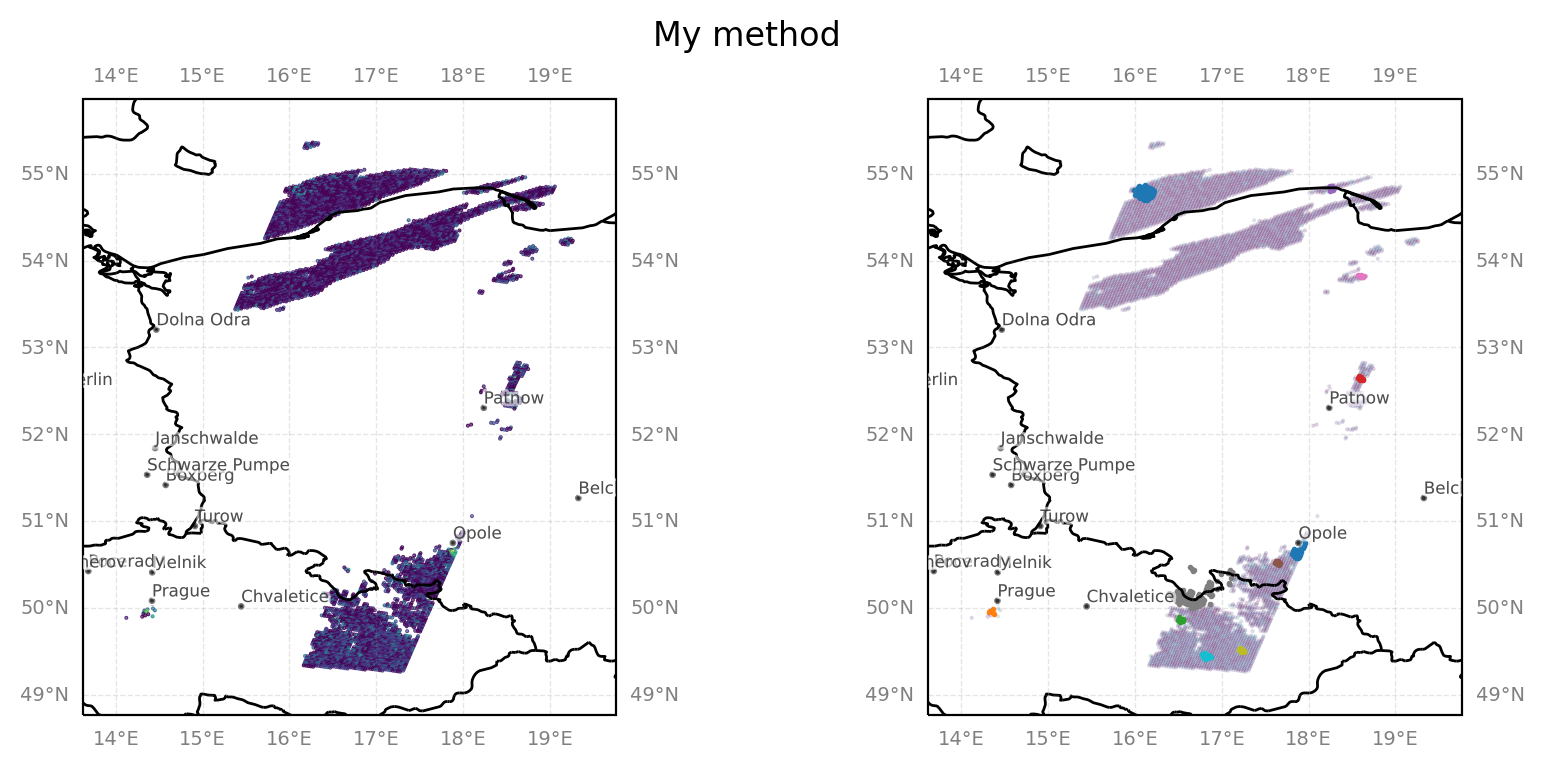

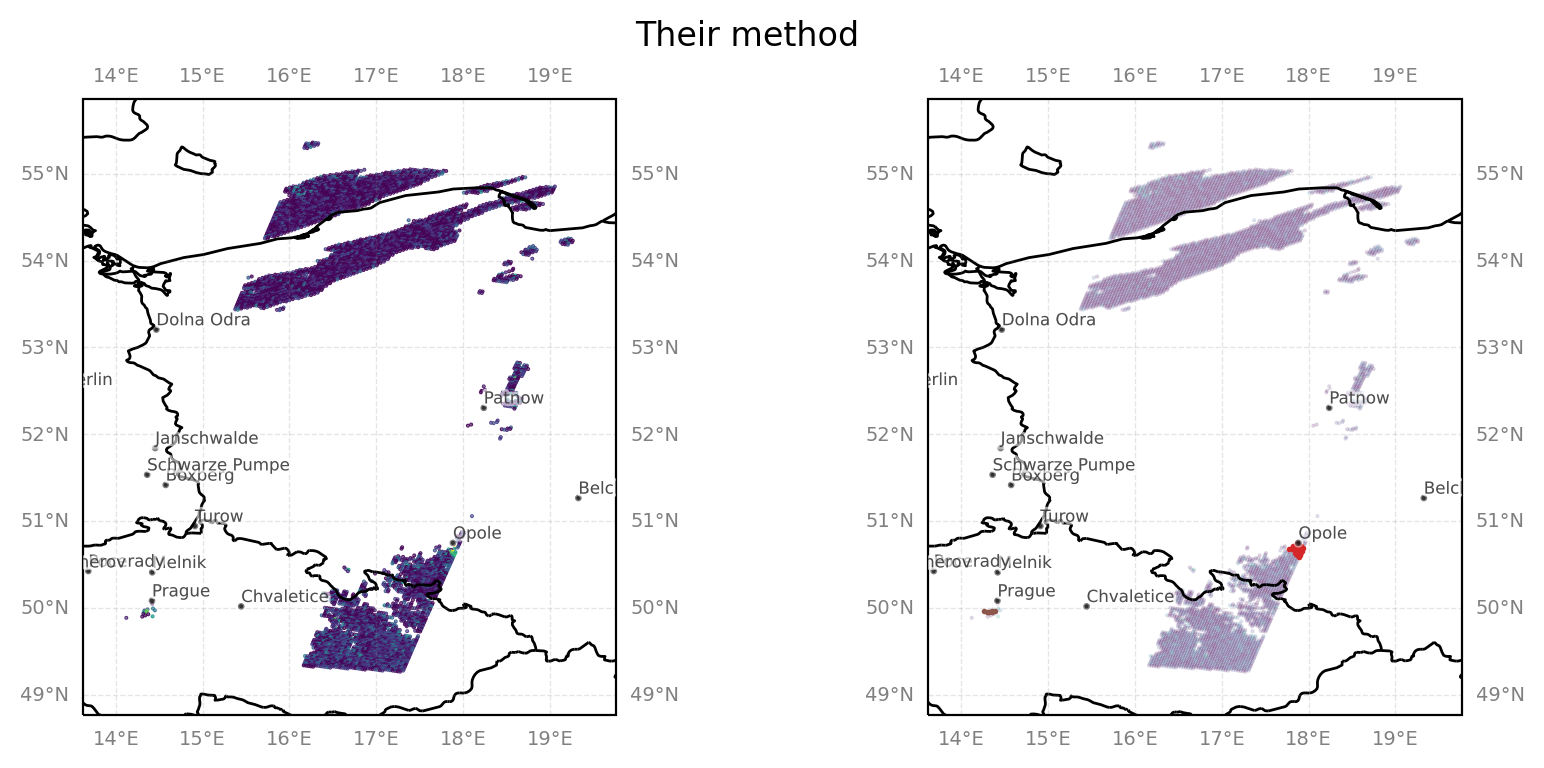

In [24]:
i=3037
plot_my_example(i)
plot_their_example(i)

- Remove files that do not include any pixels in the radius.
    - Their method might include missing pixels, which makes the comparison unfair here.
- Check amount of plumes my method found and their didn't and vice versa
- How does their method act when there are only a small number of isolated pixels?

In [ ]:
# Files that do not have points in radius
for i in range(len(disagreeing_file)):
    # Get data
    filename = os.path.join(SMARTCARB_DATA_PATH, filenames_all[disagreeing_file[i]])
    data = ddeq.smartcarb.read_level2(filename, co2_noise_scenario='low', no2_noise_scenario='high', co_noise_scenario='low', only_observations=False)
    not_nan = np.logical_not(np.isnan(np.array(data['NO2']).flatten()))
    my_lon = np.array(data['lon']).flatten()[not_nan][is_my_plume]
    my_lat = np.array(data['lat']).flatten()[not_nan][is_my_plume]
    their_lon = np.array(data['lon']).flatten()[is_their_plume]
    their_lat = np.array(data['lat']).flatten()[is_their_plume]

## Future work?

- Also try to use the algorithm on both CO2 and NO2 and try combine the knowledge of both of them.

VIESTI HUOMISELLE ELIAKSELLE:
- ~Viilaa mun menetelmän parametrit ison skaalan käyttökuntoon~
- ~Tsekkaa clusterin filtteröinti~
- ~Koita saada isot koodit pyörimään yön yli~
- ~Alustava tulosten analysointi~
- Find out if they use the haversine distance or euclidean